# Import necessary libraries

In [1]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import copy
import lightgbm as lgb
import os
import sys

/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and preprocess data set

In [2]:
EICU_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/eicu_dynamic.parquet"
EICU_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/eicu_static.parquet"
HIRID_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/hirid_dynamic.parquet"
HIRID_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/hirid_static.parquet"
MIMIC_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/mimic_dynamic.parquet"
MIMIC_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/mimic_static.parquet"
MIIV_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/miiv_static.parquet"
MIIV_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/miiv_dynamic.parquet"

## Preprocessing

In [41]:
def preprocess(DYNAMIC_PATH, STATIC_PATH, impute=True):
    # komisch: Malte macht log von bicar aber nicht von bili_dir --> würde ich swappen
    columns_to_transform = ["alp", 'alt', 'ast', 'bili', 'bili_dir', 'bnd', 'bun', 'ck', 'ckmb',
                            'crea', 'crp', 'fgn', 'fio2', 'glu', 'hgb', 'inr_pt', 'lact', 'lymph',
                             'methb', 'neut', 'o2sat', 'phos', 'plt', 'pco2', 'ph', 'po2', 'ptt', 
                             'urine', 'tnt', 'wbc']

    df_dynamic = pd.read_parquet(DYNAMIC_PATH)
    df_dynamic[columns_to_transform] = df_dynamic[columns_to_transform].apply(np.log)
    df_static = pd.read_parquet(STATIC_PATH)

    if "sex" in df_static.columns:
        df_static['sex'] = df_static['sex'].apply(lambda x: 0 if x == 'Male' else 1)

    # Rename columns to have a unified column name for IDs and time across datasets
    column_renames = {
        'icustay_id': 'stay_id', 
        'patientunitstayid': 'stay_id',
        'patientid': 'stay_id',
        'charttime': 'time',
        'labresultoffset': 'time',
        'datetime': 'time'
    }
    df_dynamic.rename(columns=column_renames, inplace=True)
    df_static.rename(columns=column_renames, inplace=True)

    # Group and calculate mean for day 1 and day 3
    df_dynday1 = df_dynamic[lambda x: x["time"].dt.days == 0].groupby("stay_id").mean()
    df_dynday3 = df_dynamic[lambda x: x['time'].dt.days == 2].groupby("stay_id").mean()
    
    # Merge with static features and fill NaN values
    df_day1 = pd.merge(df_dynday1, df_static, on="stay_id", how="outer", validate="m:1").set_index('stay_id')
    df_day3 = pd.merge(df_dynday3, df_static, on="stay_id", how="outer", validate="m:1").set_index('stay_id')

    # drop the 'time' column since it's not needed
    # drop crp and methb since only two values recorded
    df_day1.drop(columns=["time"], inplace=True)
    df_day3.drop(columns=["time"], inplace=True)

    if impute==True:
            
        # Detect -inf values in DataFrame day1
        inf_mask = df_day1.isin([-np.inf])
        # Add an indicator column based on whether -inf was replaced
        df_day1['inf_replaced'] = inf_mask.any(axis=1).astype(int)
        # Replace -inf with NaN
        df_day1.replace(-np.inf, np.nan, inplace=True)
        
        # Perform an inner join on the 'stay_id' column
        df = pd.merge(df_day3['hr'], df_day1, on='stay_id', how='inner')
        df.rename(columns={'hr_x': 'hr3',
                        'hr_y': 'hr1'}, inplace=True)
        
        df.dropna(subset=["hr3", "hr1"], inplace=True)

        # Create a new DataFrame to hold the indicators
        indicators = df.isna().astype(int)

        # Rename the indicator columns to distinguish them
        indicators.columns = [str(col) + '_was_nan' for col in df.columns]

        # Replace NaN values with the mean of the column
        for column in df.columns:
            df[column].fillna(df[column].mean(), inplace=True)

        # Concatenate the original DataFrame with the indicator DataFrame
        df = pd.concat([df, indicators], axis=1)
    
    else:
        # Replace -inf with NaN
        df_day1.replace(-np.inf, np.nan, inplace=True)
        
        # Perform an inner join on the 'stay_id' column
        df = pd.merge(df_day3['hr'], df_day1, on='stay_id', how='inner')
        df.rename(columns={'hr_x': 'hr3',
                        'hr_y': 'hr1'}, inplace=True)
        
        df.dropna(subset=["hr3", "hr1"], inplace=True)
    return df

In [42]:
df_eicu = preprocess(EICU_DATA_PATH_DYNAMIC, EICU_DATA_PATH_STATIC)

In [45]:
df_hirid = preprocess(HIRID_DATA_PATH_DYNAMIC, HIRID_DATA_PATH_STATIC)

In [46]:
df_mimic = preprocess(MIMIC_DATA_PATH_DYNAMIC, MIMIC_DATA_PATH_STATIC)

In [47]:
df_miiv = preprocess(MIIV_DATA_PATH_DYNAMIC, MIIV_DATA_PATH_STATIC)

## Automated EDA

In [ ]:
dataframes = {
    'eicu': df_eicu,
    'hirid': df_hirid,
    'mimic': df_mimic
}

for name, df in dataframes.items():

    cols_to_drop = [col for col in df.columns if '_was_nan' in col]
    df = df.drop(columns=cols_to_drop)

    # Analyze the dataset
    report = sv.analyze(df, target_feat='hr3')

    # Display the report as HTML
    report.show_html(f'{name}_Report.html')

# Predictions

## Plotting

In [9]:
def plot_mse_vs_tuning_points(n_test_range, mse_values_rf, mse_values_lgbm, name):
    plt.figure(figsize=(10, 6))
    plt.plot(n_test_range, mse_values_rf, '-o', label='Random Forest', linewidth=2, color='blue')
    plt.plot(n_test_range, mse_values_lgbm, '-o', label='LightGBM', linewidth=2, color='green')
    plt.title(f"MSE vs Number of tuning Data Points from {name}")
    plt.xlabel("Number of tuning Points")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    filename = f'eicuTO{name}.png'
    if os.path.exists(filename):
        os.remove(filename)
    plt.savefig(filename)
    plt.show()

## Training - What is the difference between continuous learning and refit?

In [11]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'max_leaf_nodes': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

In [43]:
X_train = df_eicu.drop('hr3', axis=1)
y_train = df_eicu['hr3']

In [44]:
ols = LR()
ols.fit(X_train,y_train)


LinearRegression()

In [48]:
# generate a feature name
feature_name = [col for col in X_train.columns]

In [49]:
# specify configurations as a dict
params_lgbm = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'random_state': 42,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': -1  # Suppresses standard output
}
params_rf = {
    'boosting_type': 'rf',
    'objective': 'regression',
    'metric': 'l2',
    'random_state': 42,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': -1  # Suppresses standard output
}

In [50]:
lgb_train = lgb.Dataset(data=X_train, label=y_train,free_raw_data=False)

In [51]:
lgbm = lgb.train(params_lgbm,
                lgb_train,
                feature_name=feature_name,
                valid_sets=lgb_train,
                num_boost_round=10
                )

In [52]:
rf = lgb.train(params_rf,
                lgb_train,
                feature_name=feature_name,
                valid_sets=lgb_train,
                num_boost_round=10,
                )

In [18]:
lgbm.save_model('lgbm_trained_model.txt')
rf.save_model('rf_trained_model.txt')

In [66]:
# Make predictions on the training data
y_pred_lgbm = lgbm.predict(X_train)
y_pred_rf = rf.predict(X_train)
y_pred_ols = ols.predict(X_train)


# Calculate Mean Squared Error (MSE) manually
training_mse_lgbm = np.mean((y_train - y_pred_lgbm) ** 2)
training_mse_rf = np.mean((y_train - y_pred_rf) ** 2)
training_mse_ols = np.mean((y_train - y_pred_ols) ** 2)

print("Training MSE LGBM:", training_mse_lgbm)
print("Training MSE RF:", training_mse_rf)
print("Training MSE OLS:", training_mse_ols)


In [55]:
X_test_hirid, X_test_mimic, X_test_miiv = df_hirid.drop('hr3', axis=1), df_mimic.drop('hr3', axis=1), df_miiv.drop('hr3', axis=1)
y_test_hirid, y_test_mimic, y_test_miiv = df_hirid['hr3'], df_mimic['hr3'], df_miiv['hr3']
# Do nothing prediction
dummy_mse_hirid = mean_squared_error(y_test_hirid, np.full_like(y_test_hirid, y_train.mean()))
dummy_mse_mimic = mean_squared_error(y_test_mimic, np.full_like(y_test_mimic, y_train.mean()))
dummy_mse_miiv = mean_squared_error(y_test_miiv, np.full_like(y_test_miiv, y_train.mean()))
print(f'Do nothing-mse on Hirid is {dummy_mse_hirid}, on Mimic is {dummy_mse_mimic}, on Miiv is {dummy_mse_miiv} \n')

### Hypothesis: Bad performance of Eicu on Mimic is caused by children

In [56]:
X_test_mimic = df_mimic[df_mimic["age"]>18].drop('hr3', axis=1)
y_test_mimic = df_mimic[df_mimic["age"]>18]['hr3']
# Do nothing prediction
dummy_mse_mimic = mean_squared_error(y_test_mimic, np.full_like(y_test_mimic, y_train.mean()))
print(f'Do nothing-mse on Mimic (without children) is {dummy_mse_mimic} \n')

In [ ]:
""""""""""
Do only if access to Euler otherwise pc goes in brrrr state
#grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#grid_search.fit(X_train, y_train)
#best_training_model = grid_search.best_estimator_
#print("Finished grid search and selected best estimator \n")
"""""""""""

## Refit

In [57]:
test_dataframes = {
    'hirid': df_hirid,
    'mimic': df_mimic,
    'miiv': df_miiv
    }

In [64]:
mse_values = {name: {'lgbm': [], 'rf': [], 'ols': []} for name in test_dataframes}
n_fine_tune_range = [25, 50, 100, 200, 400, 800, 1600]
for name, df in test_dataframes.items():
    X_test = df.drop('hr3', axis=1)
    y_test = df['hr3']
    
    X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = [], X_test_hirid, [], y_test_hirid

    mse_values[name]['lgbm'].append(mean_squared_error(y_evaluate,lgbm.predict(X_evaluate,num_iteration=lgbm.best_iteration))**0.5) # Base line prediction - without fine tuning
    mse_values[name]['rf'].append(mean_squared_error(y_evaluate,rf.predict(X_evaluate,num_iteration=rf.best_iteration))**0.5) # Base line prediction - without fine tuning
    mse_values[name]['ols'].append(mean_squared_error(y_evaluate,ols.predict(X_evaluate))**0.5)
    
    for n_fine_tune in n_fine_tune_range:
        X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = train_test_split(X_test, y_test, train_size=n_fine_tune, random_state=42)
        print(X_fine_tune.shape, X_evaluate.shape)

        copied_model_lgbm = copy.deepcopy(lgbm)
        tuned_lgbm=copied_model_lgbm.refit(X_fine_tune,y_fine_tune,validate_features=True)
        mse_values[name]['lgbm'].append(mean_squared_error(y_evaluate, tuned_lgbm.predict(X_evaluate,num_iteration=tuned_lgbm.best_iteration))**0.5)

        copied_model_rf = copy.deepcopy(rf)
        tuned_rf=copied_model_rf.refit(X_fine_tune,y_fine_tune,validate_features=True)
        mse_values[name]['rf'].append(mean_squared_error(y_evaluate, tuned_rf.predict(X_evaluate,num_iteration=tuned_rf.best_iteration))**0.5)
        
        mse_values[name]['ols'].append(mean_squared_error(y_evaluate, ols.predict(X_evaluate))**0.5)
    #plot_mse_vs_tuning_points([0, 25, 50, 100, 200, 400, 800, 1600], [10, 10, 10, 10, 10, 10, 10, 10], mse_values_lgbm, name)


In [90]:
mse_hirid_df = pd.DataFrame(mse_values['hirid'])
mse_mimic_df = pd.DataFrame(mse_values['mimic'])
mse_miiv_df = pd.DataFrame(mse_values['miiv'])

<Axes: >

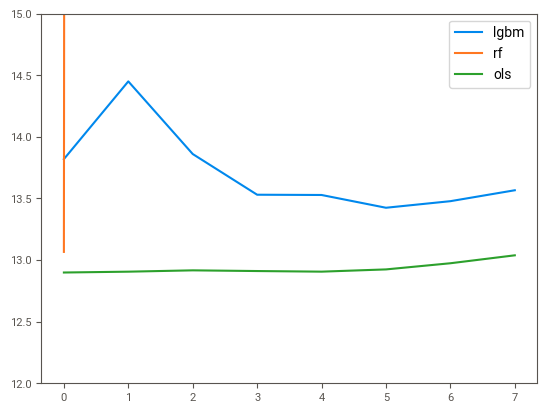

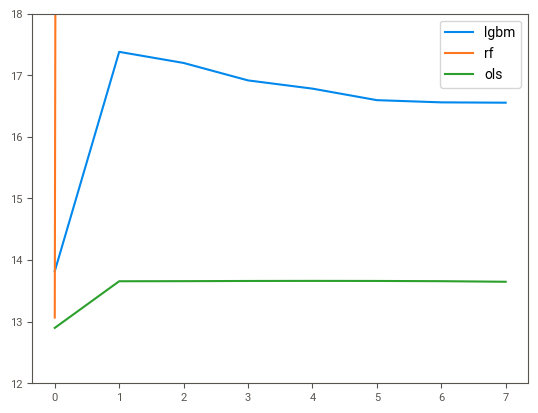

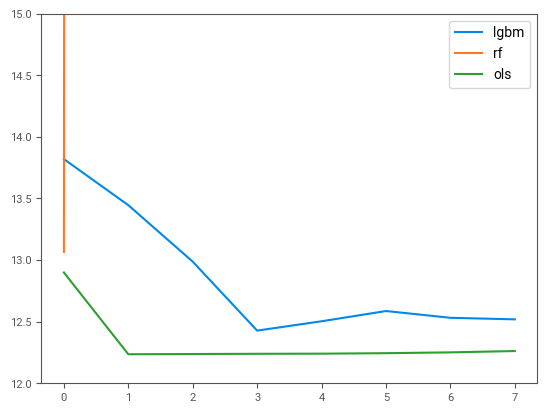

In [96]:
mse_hirid_df.plot(ylim=(12, 15))
mse_mimic_df.plot(ylim=(12, 18))
mse_miiv_df.plot(ylim=(12, 15))